### Loading Packages and Data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/alabama/2023_06_02_18_00_54/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/alabama/2023_06_02_18_00_54/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
#deaths.head()

In [5]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
#tran.transition.unique()

In [6]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 

person_time.value.sum()

696659390.1054071

# DALYs Averted

In [7]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 
daly_total = daly_total.groupby(['sex','input_draw','year','scenario']).daly.sum().reset_index()
daly_total.head()

sex  input_draw  year       scenario          daly
0  female          29  2023       baseline  84207.339166
1  female          29  2023  lifestyle_100  84207.242173
2  female          29  2023   lifestyle_50  84207.242173
3  female          29  2023   outreach_100  84193.488580
4  female          29  2023    outreach_50  84193.639013

In [8]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.loc[person_time.age != '25_to_29']
per_time_age = per_time_age.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex  year  input_draw       scenario        ptvalue
0  female  2023          29       baseline  259725.086927
1  female  2023          29  lifestyle_100  259725.086927
2  female  2023          29   lifestyle_50  259725.086927
3  female  2023          29   outreach_100  259725.240246
4  female  2023          29    outreach_50  259725.240246

In [9]:
daly_total_rate = daly_total.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  
0   0.324217  
1   0.324217  
2   0.324217  
3   0.324164  
4   0.324164

In [10]:
daly_total_baseline = daly_total.loc[daly_total.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly':'baseline'})
daly_total = daly_total.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total['averted_count'] = daly_total['baseline'] - daly_total['daly']
daly_total['averted_percent'] = 100*((daly_total['baseline'] - daly_total['daly'])/daly_total['baseline'])
daly_total.head()

sex  input_draw  year       scenario          daly      baseline  \
0  female          29  2023       baseline  84207.339166  84207.339166   
1  female          29  2023  lifestyle_100  84207.242173  84207.339166   
2  female          29  2023   lifestyle_50  84207.242173  84207.339166   
3  female          29  2023   outreach_100  84193.488580  84207.339166   
4  female          29  2023    outreach_50  84193.639013  84207.339166   

   averted_count  averted_percent  
0       0.000000         0.000000  
1       0.096994         0.000115  
2       0.096994         0.000115  
3      13.850586         0.016448  
4      13.700153         0.016270

In [11]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total_rate['averted_count'] = daly_total_rate['baseline'] - daly_total_rate['daly_rate']
daly_total_rate['averted_percent'] = 100*((daly_total_rate['baseline'] - daly_total_rate['daly_rate'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  baseline  averted_count  averted_percent  
0   0.324217  0.324217   0.000000e+00         0.000000  
1   0.324217  0.324217   3.734475e-07         0.000115  
2   0.324217  0.324217   3.734475e-07         0.000115  
3   0.324164  0.324217   5.351923e-05         0.016507  
4   0.324164  0.324217   5.294003e-05         0.016329

In [12]:
daly_sum_count = (daly_total
                .groupby(['sex','year','scenario'])
                .averted_count.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_count.head()

sex  year       scenario       mean      2.5%      97.5%
0  female  2023       baseline   0.000000  0.000000   0.000000
1  female  2023  lifestyle_100   0.585451  0.000000   4.303550
2  female  2023   lifestyle_50   0.570120  0.000000   4.301531
3  female  2023   outreach_100  30.166254  0.239164  83.094553
4  female  2023    outreach_50  23.708013  0.099544  75.588310

In [13]:
daly_sum_percent = (daly_total
                .groupby(['sex','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.000646  0.000000  0.004723
2  female  2023   lifestyle_50  0.000628  0.000000  0.004723
3  female  2023   outreach_100  0.038233  0.000290  0.113909
4  female  2023    outreach_50  0.030091  0.000115  0.100927

In [14]:
daly_rate_percent = (daly_total_rate
                .groupby(['sex','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_rate_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.000658  0.000000  0.004815
2  female  2023   lifestyle_50  0.000640  0.000000  0.004815
3  female  2023   outreach_100  0.038393  0.000290  0.114102
4  female  2023    outreach_50  0.030185  0.000115  0.101227

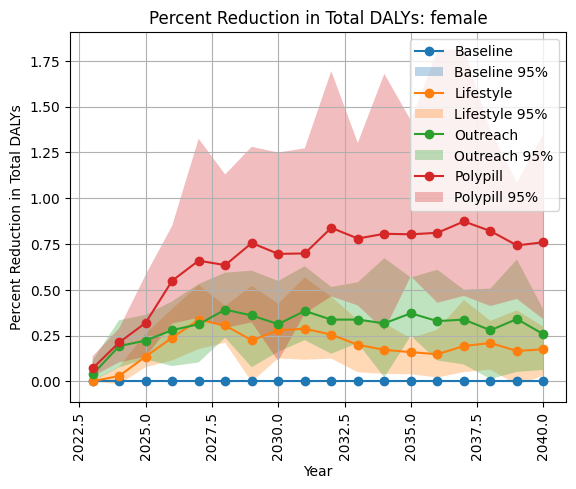

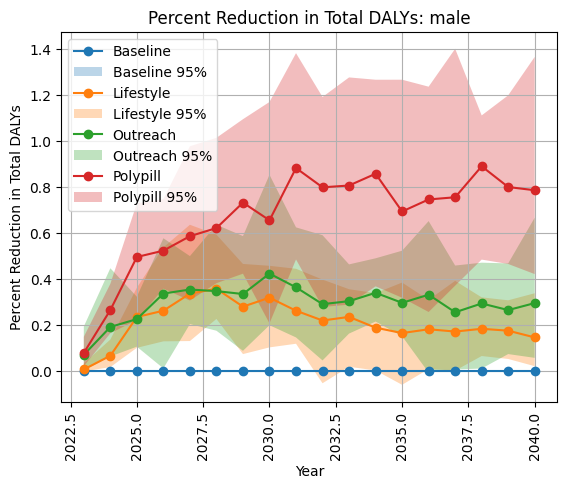

In [15]:
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Total DALYs: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

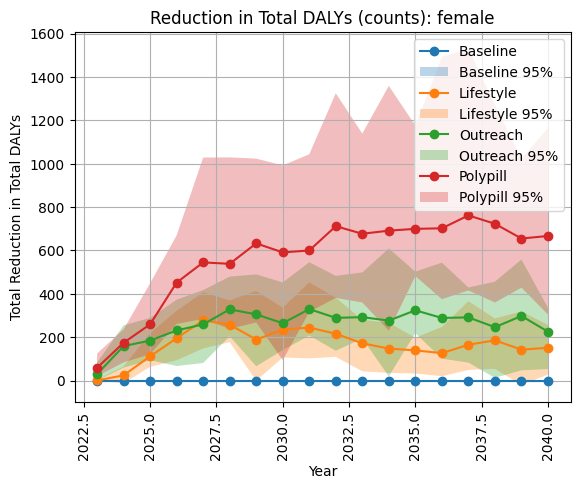

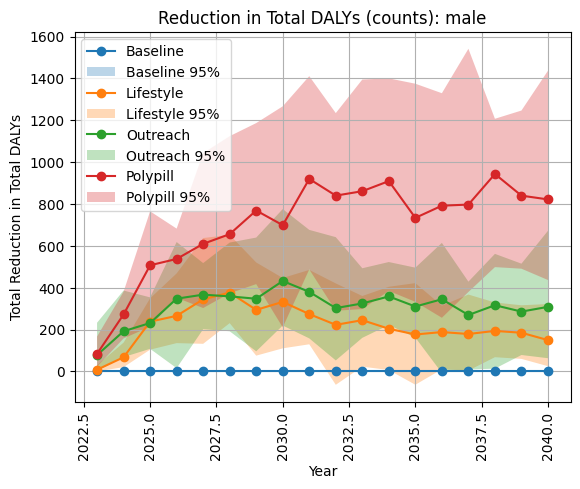

In [16]:
for sex in daly_sum_count.sex.unique(): 
    plt.figure()
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Reduction in Total DALYs (counts): {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in Total DALYs')

Note: this has NOT been multipled up to represent all of Alabama. It is useful for visualization but not the actual value of numbers. 

## DALYs Averted by Age Group

In [17]:
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 
daly_total['age_bucket'] = np.where(np.isin(daly_total['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(daly_total['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(daly_total['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
daly_total = daly_total.groupby(['sex','age_bucket','input_draw','year','scenario']).daly.sum().reset_index()
daly_total.head()

sex age_bucket  input_draw  year       scenario          daly
0  female   45_to_65          29  2023       baseline  24763.471879
1  female   45_to_65          29  2023  lifestyle_100  24763.471879
2  female   45_to_65          29  2023   lifestyle_50  24763.471879
3  female   45_to_65          29  2023   outreach_100  24763.469621
4  female   45_to_65          29  2023    outreach_50  24763.469621

In [18]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
person_time['age_bucket'] = np.where(np.isin(person_time['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(person_time['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(person_time['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
per_time_group = person_time.groupby(['age_bucket','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [19]:
daly_total_rate = daly_total.merge(per_time_group[['age_bucket','sex','input_draw','year','scenario','ptvalue']], on=['age_bucket','sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex age_bucket  input_draw  year       scenario          daly  \
0  female   45_to_65          29  2023       baseline  24763.471879   
1  female   45_to_65          29  2023  lifestyle_100  24763.471879   
2  female   45_to_65          29  2023   lifestyle_50  24763.471879   
3  female   45_to_65          29  2023   outreach_100  24763.469621   
4  female   45_to_65          29  2023    outreach_50  24763.469621   

         ptvalue  daly_rate  
0  103131.071869   0.240116  
1  103131.071869   0.240116  
2  103131.071869   0.240116  
3  103131.071869   0.240116  
4  103131.071869   0.240116

In [20]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','age_bucket','input_draw','year','baseline']], on=['sex','age_bucket','input_draw','year']) 
daly_total_rate['averted_count'] =  daly_total_rate['baseline'] - daly_total_rate['daly_rate']
daly_total_rate['averted_percent'] = 100*(( daly_total_rate['baseline'] - daly_total_rate['daly_rate'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex age_bucket  input_draw  year       scenario          daly  \
0  female   45_to_65          29  2023       baseline  24763.471879   
1  female   45_to_65          29  2023  lifestyle_100  24763.471879   
2  female   45_to_65          29  2023   lifestyle_50  24763.471879   
3  female   45_to_65          29  2023   outreach_100  24763.469621   
4  female   45_to_65          29  2023    outreach_50  24763.469621   

         ptvalue  daly_rate  baseline  averted_count  averted_percent  
0  103131.071869   0.240116  0.240116   0.000000e+00         0.000000  
1  103131.071869   0.240116  0.240116   0.000000e+00         0.000000  
2  103131.071869   0.240116  0.240116   0.000000e+00         0.000000  
3  103131.071869   0.240116  0.240116   2.189314e-08         0.000009  
4  103131.071869   0.240116  0.240116   2.189314e-08         0.000009

In [21]:
daly_sum_count = (daly_total_rate
                .groupby(['sex','age_bucket','year','scenario'])
                .averted_count.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_count.head()

sex age_bucket  year       scenario          mean          2.5%  \
0  female   45_to_65  2023       baseline  0.000000e+00  0.000000e+00   
1  female   45_to_65  2023  lifestyle_100  1.115511e-07 -3.953211e-08   
2  female   45_to_65  2023   lifestyle_50  3.432944e-08  0.000000e+00   
3  female   45_to_65  2023   outreach_100  1.259777e-04 -1.007621e-07   
4  female   45_to_65  2023    outreach_50  1.258386e-04 -2.220867e-07   

          97.5%  
0  0.000000e+00  
1  8.310579e-07  
2  1.930584e-07  
3  5.456981e-04  
4  5.458569e-04

In [22]:
daly_sum_percent = (daly_total_rate
                .groupby(['sex','age_bucket','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_percent.head()

sex age_bucket  year       scenario      mean      2.5%     97.5%
0  female   45_to_65  2023       baseline  0.000000  0.000000  0.000000
1  female   45_to_65  2023  lifestyle_100  0.000038 -0.000017  0.000282
2  female   45_to_65  2023   lifestyle_50  0.000013  0.000000  0.000068
3  female   45_to_65  2023   outreach_100  0.054285 -0.000036  0.246657
4  female   45_to_65  2023    outreach_50  0.054219 -0.000103  0.246682

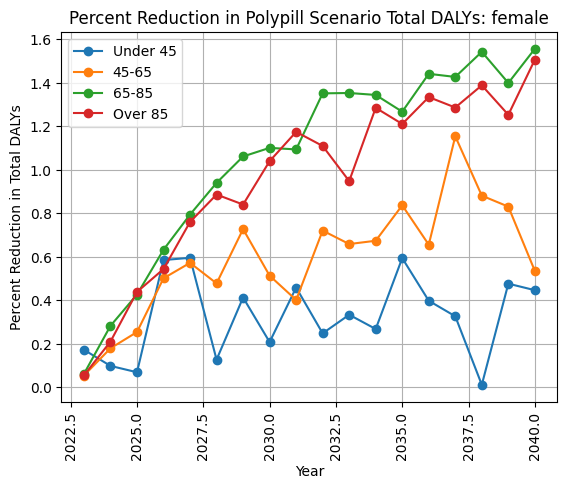

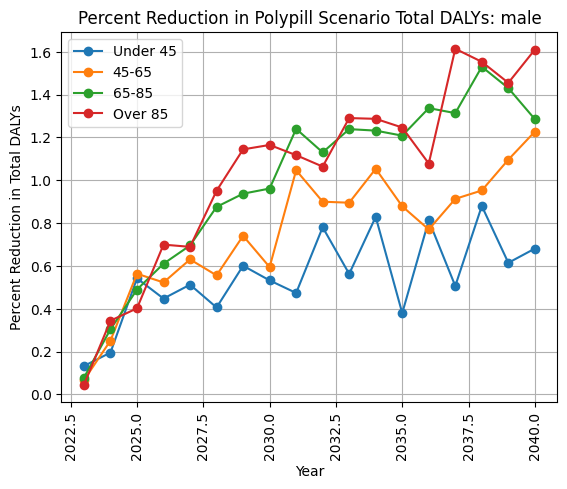

In [23]:
##Polypill Scenario First 
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Polypill Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

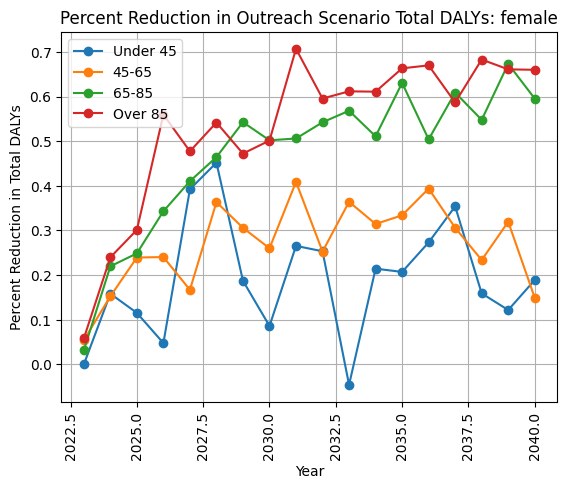

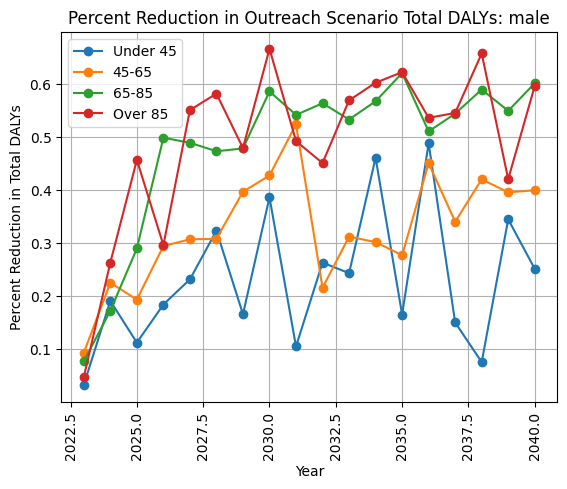

In [24]:
##Outreach Scenario  
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Outreach Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

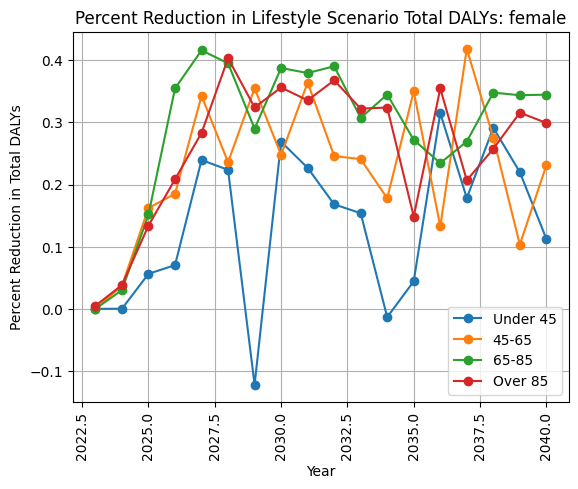

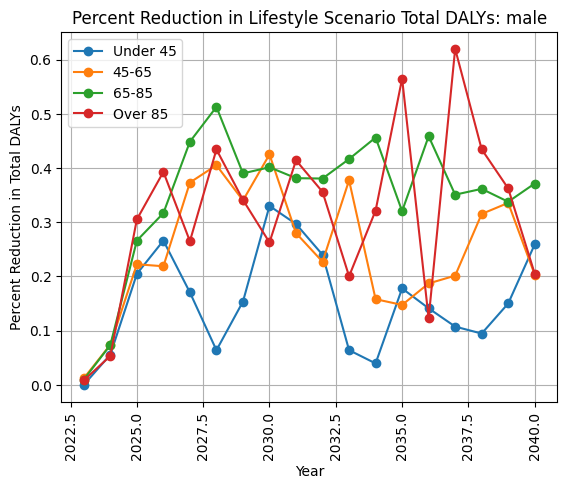

In [25]:
##Lifestyle Scenario  
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Lifestyle Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

# Deaths Averted

## Total Deaths Averted

In [26]:
deaths_all = deaths.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_all.head()

sex  year  scenario  input_draw   value
0  female  2023  baseline          29  4525.0
1  female  2023  baseline         232  4078.0
2  female  2023  baseline         357  4189.0
3  female  2023  baseline         394  4065.0
4  female  2023  baseline         602  4318.0

In [27]:
deaths_baseline = deaths_all.loc[deaths_all.scenario == 'baseline']
deaths_baseline = deaths_baseline.rename(columns = {'value':'baseline'})
deaths_total = deaths_all.merge(deaths_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
deaths_total['averted_count'] = deaths_total['baseline'] - deaths_total['value']
deaths_total['averted_percent'] = 100*((deaths_total['baseline'] - deaths_total['value'])/deaths_total['baseline'])
deaths_total

sex  year       scenario  input_draw   value  baseline  \
0     female  2023       baseline          29  4525.0    4525.0   
1     female  2023  lifestyle_100          29  4525.0    4525.0   
2     female  2023   lifestyle_50          29  4525.0    4525.0   
3     female  2023   outreach_100          29  4524.0    4525.0   
...      ...   ...            ...         ...     ...       ...   
2516    male  2040   outreach_100         946  5487.0    5481.0   
2517    male  2040    outreach_50         946  5480.0    5481.0   
2518    male  2040   polypill_100         946  5473.0    5481.0   
2519    male  2040    polypill_50         946  5475.0    5481.0   

      averted_count  averted_percent  
0               0.0         0.000000  
1               0.0         0.000000  
2               0.0         0.000000  
3               1.0         0.022099  
...             ...              ...  
2516           -6.0        -0.109469  
2517            1.0         0.018245  
2518            8.0         0.145959  
2519            6.0         0.109469  

[2520 rows x 8 columns]

In [28]:
deaths_summ_count = (deaths_total
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0   0.0  0.000
1  female  2023  lifestyle_100   0.1   0.0  0.775
2  female  2023   lifestyle_50   0.1   0.0  0.775
3  female  2023   outreach_100   1.9   0.0  5.325
4  female  2023    outreach_50   1.4   0.0  3.775

In [29]:
deaths_summ_percent = (deaths_total
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent.head()

sex  year       scenario      mean  2.5%     97.5%
0  female  2023       baseline  0.000000   0.0  0.000000
1  female  2023  lifestyle_100  0.002042   0.0  0.015829
2  female  2023   lifestyle_50  0.002042   0.0  0.015829
3  female  2023   outreach_100  0.043776   0.0  0.130505
4  female  2023    outreach_50  0.032418   0.0  0.092374

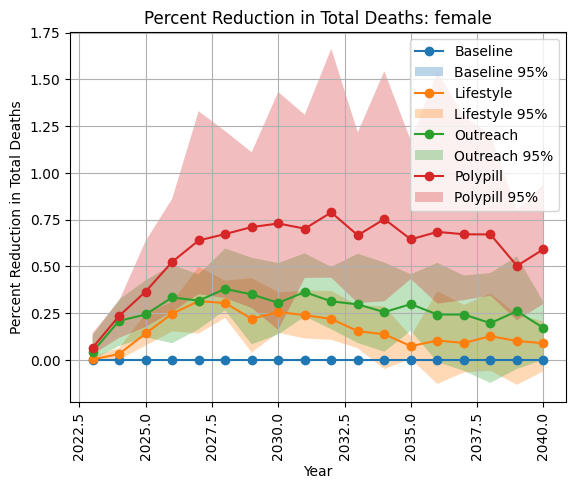

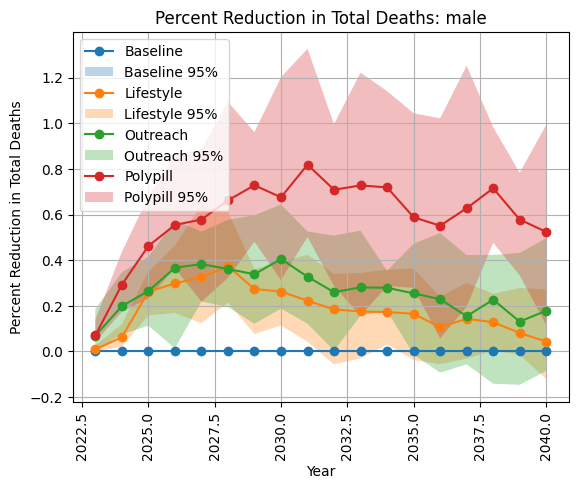

In [30]:
for sex in deaths_summ_percent.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Total Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total Deaths')


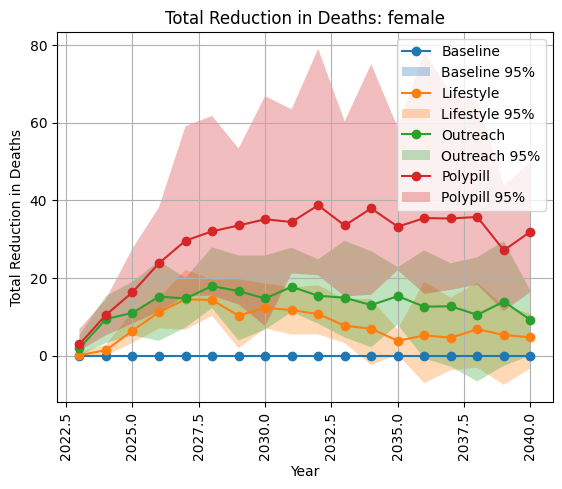

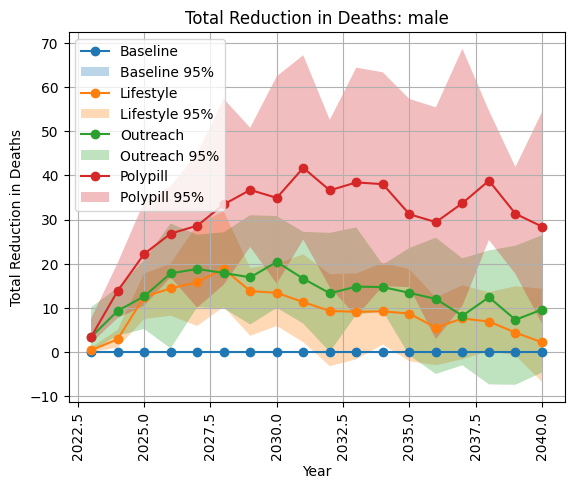

In [31]:
for sex in deaths_summ_count.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in Deaths')

Note: This has not been multiplied up to reflect the full population 

## CVD Deaths Averted 

In [32]:
deaths_cvd = deaths.loc[deaths.cause != 'other_causes']
deaths_cvd = deaths_cvd.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_cvd_rate = deaths_cvd.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
deaths_cvd_rate['cvd_death_rate'] = deaths_cvd_rate['value'] / deaths_cvd_rate['ptvalue']
deaths_cvd_rate.head()

sex  year  scenario  input_draw   value        ptvalue  cvd_death_rate
0  female  2023  baseline          29  2520.0  259725.086927        0.009703
1  female  2023  baseline         232  2813.0  260908.254620        0.010782
2  female  2023  baseline         357  2406.0  259679.934292        0.009265
3  female  2023  baseline         394  2923.0  260812.046543        0.011207
4  female  2023  baseline         602  2596.0  260163.734428        0.009978

In [33]:
deaths_baseline = deaths_cvd_rate.loc[deaths_cvd_rate.scenario == 'baseline']
deaths_baseline = deaths_baseline.rename(columns = {'value':'baseline'})
deaths_cvd_rate = deaths_cvd_rate.merge(deaths_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
deaths_cvd_rate['averted_count'] = deaths_cvd_rate['baseline'] - deaths_cvd_rate['value']
deaths_cvd_rate['averted_percent'] = 100*((deaths_cvd_rate['baseline'] - deaths_cvd_rate['value'])/deaths_cvd_rate['baseline'])
deaths_cvd_rate

sex  year       scenario  input_draw   value        ptvalue  \
0     female  2023       baseline          29  2520.0  259725.086927   
1     female  2023  lifestyle_100          29  2520.0  259725.086927   
2     female  2023   lifestyle_50          29  2520.0  259725.086927   
3     female  2023   outreach_100          29  2519.0  259725.240246   
...      ...   ...            ...         ...     ...            ...   
2516    male  2040   outreach_100         946  3628.0  233594.666667   
2517    male  2040    outreach_50         946  3626.0  233456.449008   
2518    male  2040   polypill_100         946  3605.0  233772.057495   
2519    male  2040    polypill_50         946  3615.0  233548.824093   

      cvd_death_rate  baseline  averted_count  averted_percent  
0           0.009703    2520.0            0.0         0.000000  
1           0.009703    2520.0            0.0         0.000000  
2           0.009703    2520.0            0.0         0.000000  
3           0.009699    2520.0            1.0         0.039683  
...              ...       ...            ...              ...  
2516        0.015531    3629.0            1.0         0.027556  
2517        0.015532    3629.0            3.0         0.082667  
2518        0.015421    3629.0           24.0         0.661339  
2519        0.015479    3629.0           14.0         0.385781  

[2520 rows x 10 columns]

In [34]:
deaths_summ_percent = (deaths_cvd_rate
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent.head()

sex  year       scenario      mean  2.5%     97.5%
0  female  2023       baseline  0.000000   0.0  0.000000
1  female  2023  lifestyle_100  0.003520   0.0  0.027279
2  female  2023   lifestyle_50  0.003520   0.0  0.027279
3  female  2023   outreach_100  0.064494   0.0  0.160624
4  female  2023    outreach_50  0.050171   0.0  0.134110

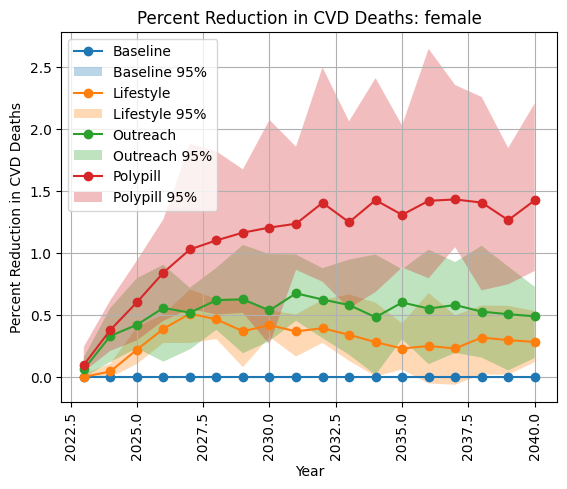

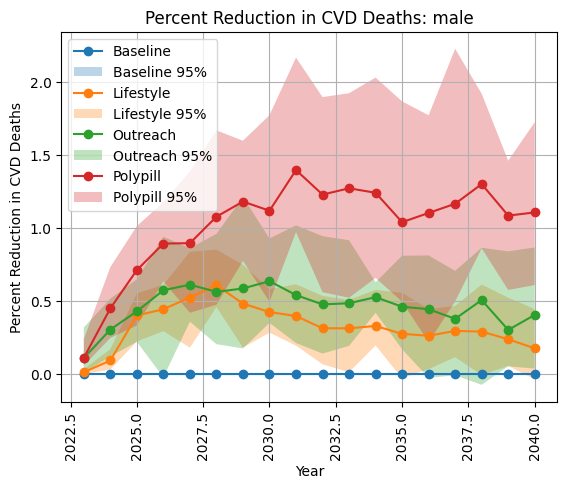

In [35]:
for sex in deaths_summ_percent.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in CVD Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in CVD Deaths')


In [36]:
polypill_locations_cvd_deaths = deaths_summ_percent.loc[deaths_summ_percent.scenario=='polypill_100']
states = ['Alabama','Washington','California','New Jersey','Michigan','Oregon','Nevada','Mississippi','Georgia','Iowa','Missouri','Arkansas','New York','Maine','Vermont']

In [49]:
for state in states:
    rand = np.random.uniform(0.5,1.5,1)
    polypill_locations_cvd_deaths[state] = polypill_locations_cvd_deaths['mean'] * rand
    for i in range(len(polypill_locations_cvd_deaths)): 
        rand_2 = np.random.uniform(0.85,1.15,1)
        polypill_locations_cvd_deaths[state].iloc[i] = polypill_locations_cvd_deaths[state].iloc[i] * rand_2

In [50]:
polypill_locations_cvd_deaths

sex  year      scenario      mean      2.5%     97.5%   Alabama  \
5    female  2023  polypill_100  0.099833  0.046208  0.245019  0.051468   
12   female  2024  polypill_100  0.381706  0.213295  0.621041  0.211928   
19   female  2025  polypill_100  0.604538  0.296999  0.941275  0.312141   
26   female  2026  polypill_100  0.844207  0.455154  1.274182  0.450845   
..      ...   ...           ...       ...       ...       ...       ...   
229    male  2037  polypill_100  1.165232  0.497476  2.225018  0.716975   
236    male  2038  polypill_100  1.299780  0.860796  1.918170  0.823770   
243    male  2039  polypill_100  1.084183  0.575684  1.459709  0.706728   
250    male  2040  polypill_100  1.105835  0.609158  1.722849  0.596294   

     Washington  California  New Jersey  ...    Oregon    Nevada  Mississippi  \
5      0.089754    0.073523    0.085616  ...  0.058003  0.067036     0.084372   
12     0.298315    0.313217    0.301856  ...  0.173144  0.245121     0.331708   
19     0.534476    0.453576    0.586900  ...  0.330987  0.425461     0.562231   
26     0.743474    0.574379    0.747902  ...  0.460417  0.594948     0.841795   
..          ...         ...         ...  ...       ...       ...          ...   
229    0.923461    0.836673    1.081864  ...  0.647259  0.827093     1.194670   
236    1.169463    0.867274    1.210327  ...  0.634301  1.012017     1.197016   
243    0.866765    0.878772    1.014248  ...  0.488380  0.897852     0.944330   
250    1.049127    0.926195    0.951534  ...  0.587412  0.786428     1.111617   

      Georgia      Iowa  Missouri  Arkansas  New York     Maine   Vermont  
5    0.068841  0.124342  0.050240  0.111982  0.131496  0.150228  0.116631  
12   0.247164  0.570367  0.190228  0.545097  0.522483  0.534595  0.504653  
19   0.330095  0.773288  0.388253  0.905227  0.745325  0.840584  0.801364  
26   0.558274  1.022262  0.419325  1.103179  0.970731  1.171457  1.248869  
..        ...       ...       ...       ...       ...       ...       ...  
229  0.804495  1.712498  0.595366  1.405627  1.323653  1.759321  1.583091  
236  0.840805  1.862236  0.816174  1.720947  1.454857  1.753064  1.611104  
243  0.602240  1.464900  0.656059  1.561549  1.239376  1.526952  1.449530  
250  0.793950  1.635379  0.619921  1.259873  1.476455  1.377587  1.322762  

[36 rows x 21 columns]

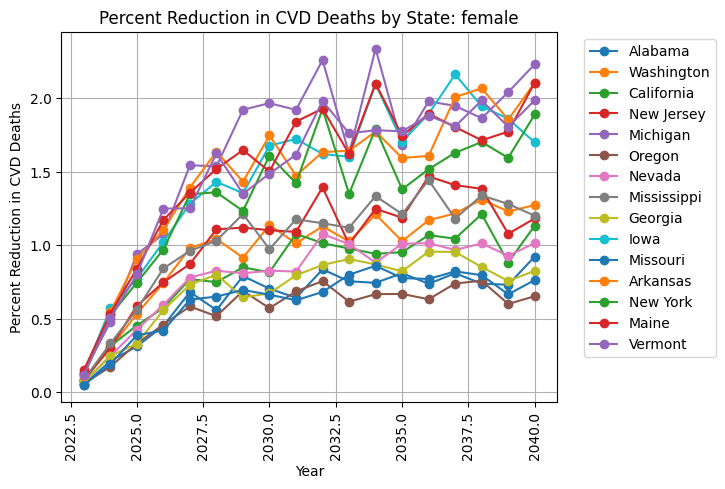

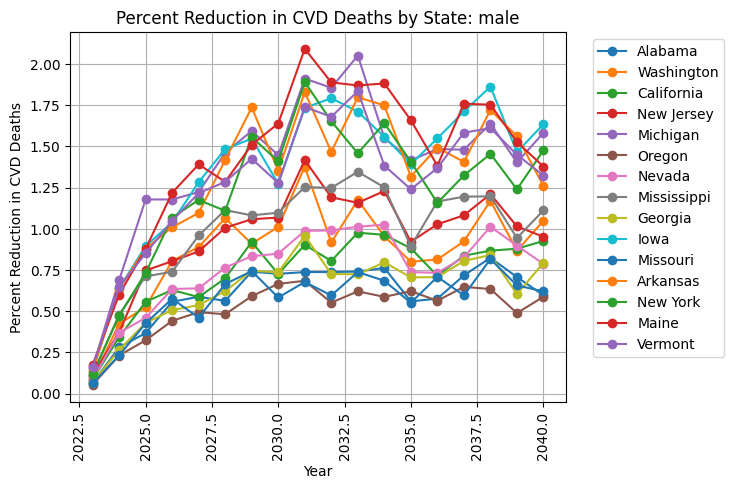

In [51]:
for sex in polypill_locations_cvd_deaths.sex.unique(): 
    plt.figure()
    subdata = polypill_locations_cvd_deaths.loc[(polypill_locations_cvd_deaths.sex==sex)]
    for state in states: 
        plt.plot(subdata['year'], subdata[state], marker = 'o',label=state)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.title(f'Percent Reduction in CVD Deaths by State: {sex}')
    plt.ylabel('Percent Reduction in CVD Deaths')

# First Time Incident Cases Averted

## Stroke Cases Averted

In [46]:
tran_stroke = tran.loc[tran.transition == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke']
tran_stroke = tran_stroke.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()

In [47]:
tran_baseline = tran_stroke.loc[tran_stroke.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_stroke = tran_stroke.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_stroke['averted_count'] = tran_stroke['baseline'] - tran_stroke['value']
tran_stroke['averted_percent'] = 100*((tran_stroke['baseline'] - tran_stroke['value'])/tran_stroke['baseline'])
tran_stroke.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  female          29  2023       baseline  508.0     508.0            0.0   
1  female          29  2023  lifestyle_100  507.0     508.0            1.0   
2  female          29  2023   lifestyle_50  507.0     508.0            1.0   
3  female          29  2023   outreach_100  503.0     508.0            5.0   
4  female          29  2023    outreach_50  507.0     508.0            1.0   

   averted_percent  
0         0.000000  
1         0.196850  
2         0.196850  
3         0.984252  
4         0.196850

In [48]:
stroke_summ_count = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0   0.0  0.000
1  female  2023  lifestyle_100   0.4   0.0  1.000
2  female  2023   lifestyle_50   0.3   0.0  1.000
3  female  2023   outreach_100   3.1   1.0  4.775
4  female  2023    outreach_50   1.5   0.0  3.000

In [49]:
stroke_summ_percent = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.098765  0.000000  0.285262
2  female  2023   lifestyle_50  0.074784  0.000000  0.285262
3  female  2023   outreach_100  0.720108  0.280664  1.020426
4  female  2023    outreach_50  0.358621  0.000000  0.706981

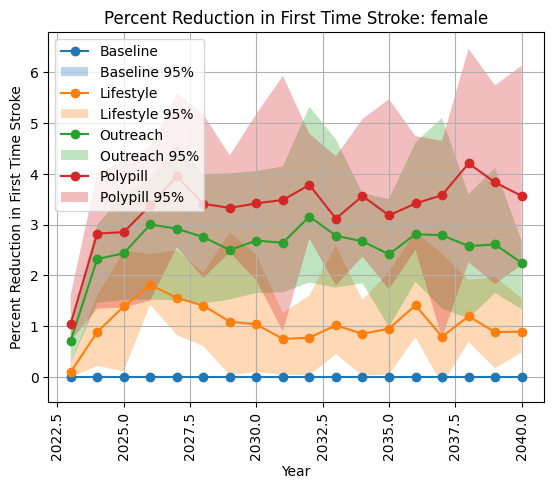

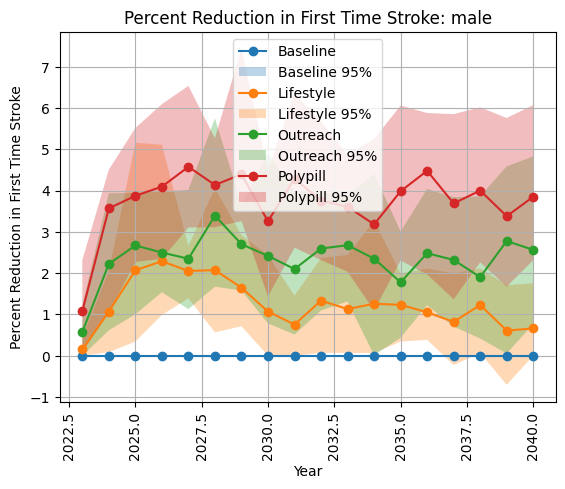

In [50]:
for sex in stroke_summ_percent.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time Stroke')


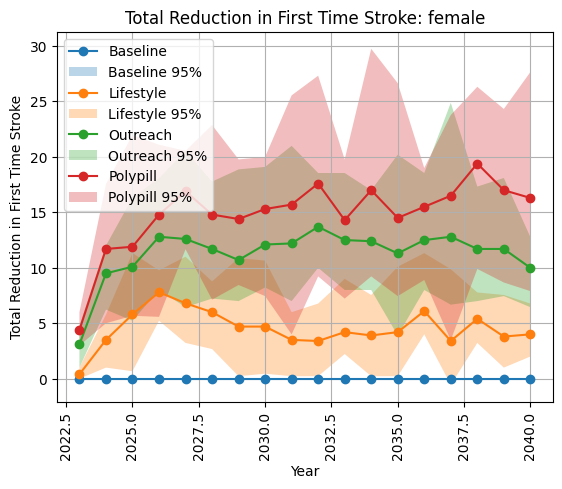

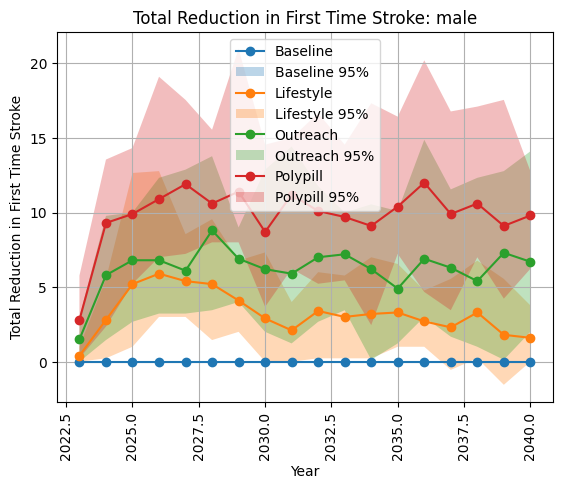

In [51]:
for sex in stroke_summ_count.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time Stroke')


Note: again, not multiplied up to represent all of Alabama

## First Time Acute MI

In [52]:
tran_mi = tran.loc[tran.transition == 'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']
tran_mi = tran_mi.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()

In [53]:
tran_baseline = tran_mi.loc[tran_mi.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_mi = tran_mi.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_mi['averted_count'] = tran_mi['baseline'] - tran_mi['value']
tran_mi['averted_percent'] = 100*((tran_mi['baseline'] - tran_mi['value'])/tran_mi['baseline'])
tran_mi.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  female          29  2023       baseline  497.0     497.0            0.0   
1  female          29  2023  lifestyle_100  497.0     497.0            0.0   
2  female          29  2023   lifestyle_50  497.0     497.0            0.0   
3  female          29  2023   outreach_100  494.0     497.0            3.0   
4  female          29  2023    outreach_50  496.0     497.0            1.0   

   averted_percent  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.603622  
4         0.201207

In [54]:
mi_summ_count = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0  0.00  0.000
1  female  2023  lifestyle_100   0.6  0.00  1.775
2  female  2023   lifestyle_50   0.2  0.00  1.000
3  female  2023   outreach_100   5.4  3.00  9.550
4  female  2023    outreach_50   2.9 -0.55  5.775

In [55]:
mi_summ_percent = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.106005  0.000000  0.302748
2  female  2023   lifestyle_50  0.028479  0.000000  0.153800
3  female  2023   outreach_100  0.945564  0.497773  1.498224
4  female  2023    outreach_50  0.496952 -0.122829  0.957328

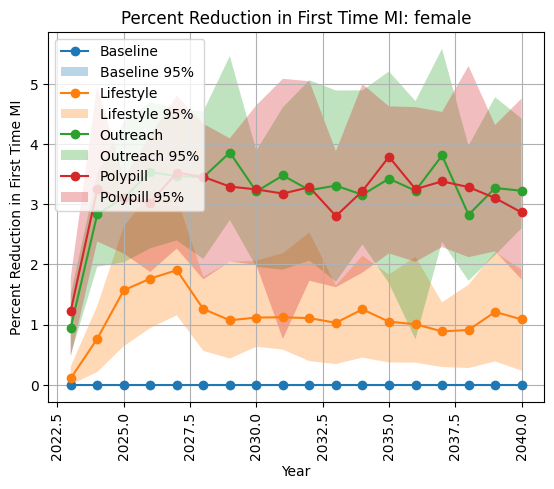

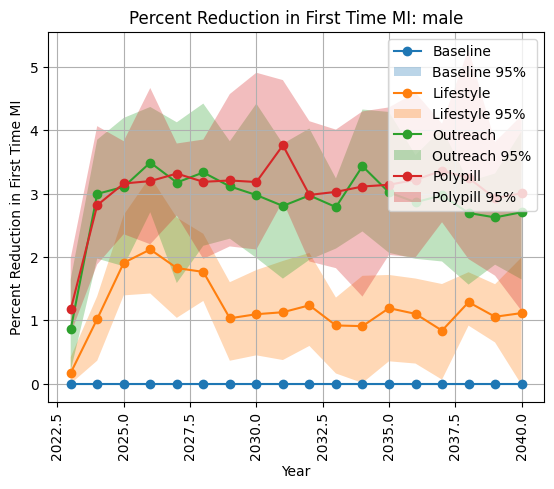

In [56]:
for sex in mi_summ_percent.sex.unique(): 
    plt.figure()
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time MI')


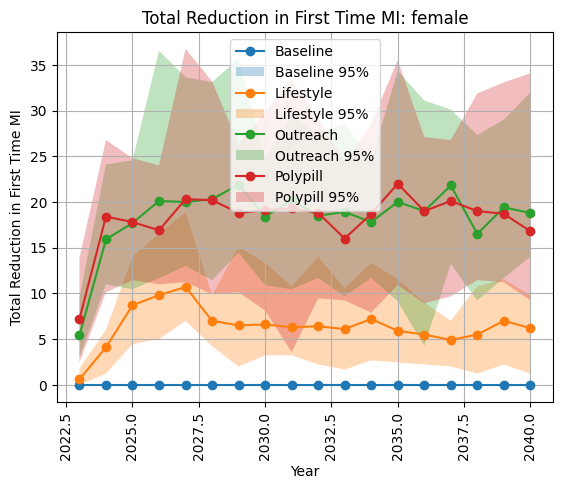

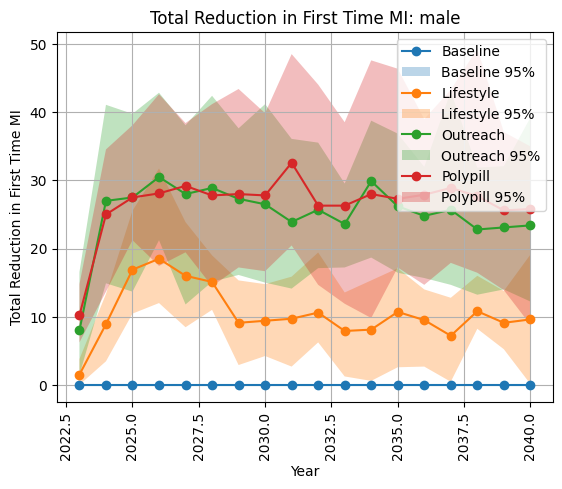

In [57]:
for sex in mi_summ_count.sex.unique(): 
    plt.figure()
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time MI')


## And First Time Heart Failure

In [58]:
tran_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
tran_HF['age_bucket'] = np.where(np.isin(tran_HF['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(tran_HF['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(tran_HF['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
tran_HF_sex = tran_HF.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age = tran_HF.groupby(['sex','age','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age_bucket = tran_HF.groupby(['sex','age_bucket','input_draw','year','scenario']).value.sum().reset_index()
tran_HF_age_bucket.head()

sex age_bucket  input_draw  year       scenario  value
0  female   45_to_65          29  2023       baseline  380.0
1  female   45_to_65          29  2023  lifestyle_100  380.0
2  female   45_to_65          29  2023   lifestyle_50  380.0
3  female   45_to_65          29  2023   outreach_100  380.0
4  female   45_to_65          29  2023    outreach_50  380.0

In [53]:
person_time['age_bucket'] = np.where(np.isin(person_time['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(person_time['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(person_time['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex','age', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age_bucket = person_time.groupby(['sex','age_bucket', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age_bucket.head()

sex age_bucket  year  input_draw       scenario        ptvalue
0  female   45_to_65  2023          29       baseline  103131.071869
1  female   45_to_65  2023          29  lifestyle_100  103131.071869
2  female   45_to_65  2023          29   lifestyle_50  103131.071869
3  female   45_to_65  2023          29   outreach_100  103131.071869
4  female   45_to_65  2023          29    outreach_50  103131.071869

In [61]:
tran_HF_rate = tran_HF_age_bucket.merge(per_time_age_bucket[['sex','age_bucket', 'year', 'input_draw','scenario','ptvalue']], on=['sex', 'age_bucket','year', 'input_draw','scenario'])
tran_HF_rate['hf_rate'] = tran_HF_rate['value'] / tran_HF_rate['ptvalue']
tran_baseline = tran_HF_rate.loc[tran_HF_rate.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'hf_rate':'baseline'})
tran_HF_rate = tran_HF_rate.merge(tran_baseline[['sex','age_bucket','input_draw','year','baseline']], on=['sex','age_bucket','input_draw','year']) 
tran_HF_rate['averted_count'] = tran_HF_rate['baseline'] - tran_HF_rate['hf_rate']
tran_HF_rate['averted_percent'] = 100*((tran_HF_rate['baseline'] - tran_HF_rate['hf_rate'])/tran_HF_rate['baseline'])
tran_HF_rate.head()

sex age_bucket  input_draw  year       scenario  value        ptvalue  \
0  female   45_to_65          29  2023       baseline  380.0  103131.071869   
1  female   45_to_65          29  2023  lifestyle_100  380.0  103131.071869   
2  female   45_to_65          29  2023   lifestyle_50  380.0  103131.071869   
3  female   45_to_65          29  2023   outreach_100  380.0  103131.071869   
4  female   45_to_65          29  2023    outreach_50  380.0  103131.071869   

    hf_rate  baseline  averted_count  averted_percent  
0  0.003685  0.003685            0.0              0.0  
1  0.003685  0.003685            0.0              0.0  
2  0.003685  0.003685            0.0              0.0  
3  0.003685  0.003685            0.0              0.0  
4  0.003685  0.003685            0.0              0.0

In [64]:
HF_summ_percent = (tran_HF_rate
                      .groupby(['sex','age_bucket', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex age_bucket  year       scenario      mean      2.5%     97.5%
0  female   45_to_65  2023       baseline  0.000000  0.000000  0.000000
1  female   45_to_65  2023  lifestyle_100  0.020504 -0.214681  0.252439
2  female   45_to_65  2023   lifestyle_50  0.030193 -0.170705  0.261473
3  female   45_to_65  2023   outreach_100  0.031738 -0.417743  0.603558
4  female   45_to_65  2023    outreach_50  0.100776  0.000000  0.656097

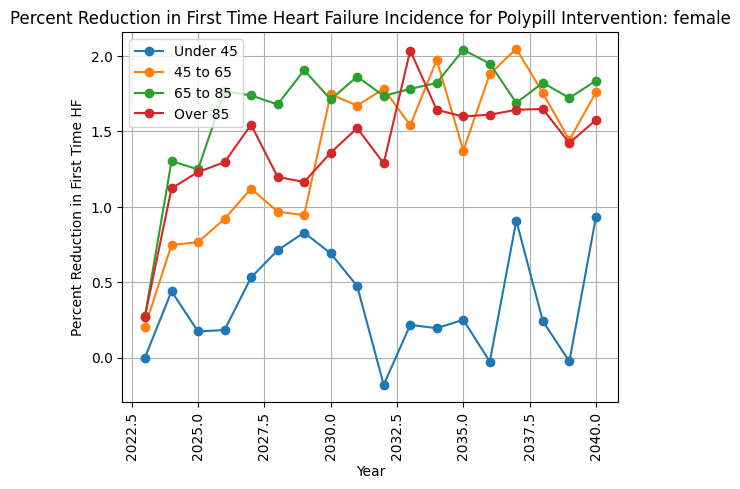

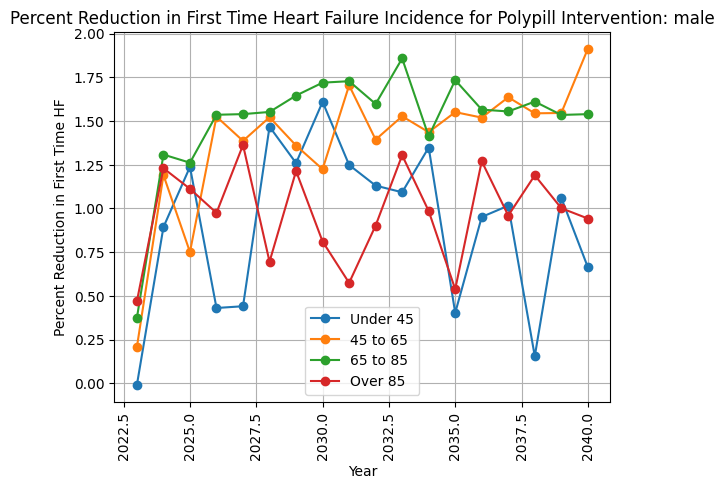

In [67]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Heart Failure Incidence for Polypill Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

## Percent Reduction in Heart Failure Prevalence

In [70]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
state_person_time_hf = state_person_time.loc[state_person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_heart_failure_residual'])].reset_index()
state_person_time_hf['age_bucket'] = np.where(np.isin(state_person_time_hf['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(state_person_time_hf['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(state_person_time_hf['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
hf_per_time_sex = state_person_time_hf.groupby(['sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age = state_person_time_hf.groupby(['age','sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age_bucket = state_person_time_hf.groupby(['age_bucket','sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
hf_per_time_age_bucket.head()

age_bucket     sex  year  input_draw       scenario        value
0   45_to_65  female  2023          29       baseline  1159.403149
1   45_to_65  female  2023          29  lifestyle_100  1159.403149
2   45_to_65  female  2023          29   lifestyle_50  1159.403149
3   45_to_65  female  2023          29   outreach_100  1159.556468
4   45_to_65  female  2023          29    outreach_50  1159.556468

In [72]:
hf_prev_rate = hf_per_time_age_bucket.merge(per_time_age_bucket[['sex','age_bucket', 'year', 'input_draw','scenario','ptvalue']], on=['sex', 'age_bucket','year', 'input_draw','scenario'])
hf_prev_rate['hf_prev_rate'] = hf_prev_rate['value'] / hf_prev_rate['ptvalue']
hf_prev_baseline = hf_prev_rate.loc[hf_prev_rate.scenario == 'baseline']
hf_prev_baseline = hf_prev_baseline.rename(columns = {'hf_prev_rate':'baseline'})
hf_prev_rate = hf_prev_rate.merge(hf_prev_baseline[['sex','age_bucket','input_draw','year','baseline']], on=['sex','age_bucket','input_draw','year']) 
hf_prev_rate['averted_count'] = hf_prev_rate['baseline'] - hf_prev_rate['hf_prev_rate']
hf_prev_rate['averted_percent'] = 100*((hf_prev_rate['baseline'] - hf_prev_rate['hf_prev_rate'])/hf_prev_rate['baseline'])
hf_prev_rate.head()

age_bucket     sex  year  input_draw       scenario        value  \
0   45_to_65  female  2023          29       baseline  1159.403149   
1   45_to_65  female  2023          29  lifestyle_100  1159.403149   
2   45_to_65  female  2023          29   lifestyle_50  1159.403149   
3   45_to_65  female  2023          29   outreach_100  1159.556468   
4   45_to_65  female  2023          29    outreach_50  1159.556468   

         ptvalue  hf_prev_rate  baseline  averted_count  averted_percent  
0  103131.071869      0.011242  0.011242       0.000000         0.000000  
1  103131.071869      0.011242  0.011242       0.000000         0.000000  
2  103131.071869      0.011242  0.011242       0.000000         0.000000  
3  103131.071869      0.011244  0.011242      -0.000001        -0.013224  
4  103131.071869      0.011244  0.011242      -0.000001        -0.013224

In [73]:
HF_summ_percent = (hf_prev_rate
                      .groupby(['sex','age_bucket', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex age_bucket  year       scenario      mean      2.5%     97.5%
0  female   45_to_65  2023       baseline  0.000000  0.000000  0.000000
1  female   45_to_65  2023  lifestyle_100  0.002168 -0.014638  0.028039
2  female   45_to_65  2023   lifestyle_50 -0.001101 -0.013324  0.004791
3  female   45_to_65  2023   outreach_100  0.000274 -0.044735  0.034249
4  female   45_to_65  2023    outreach_50  0.005611 -0.010249  0.045866

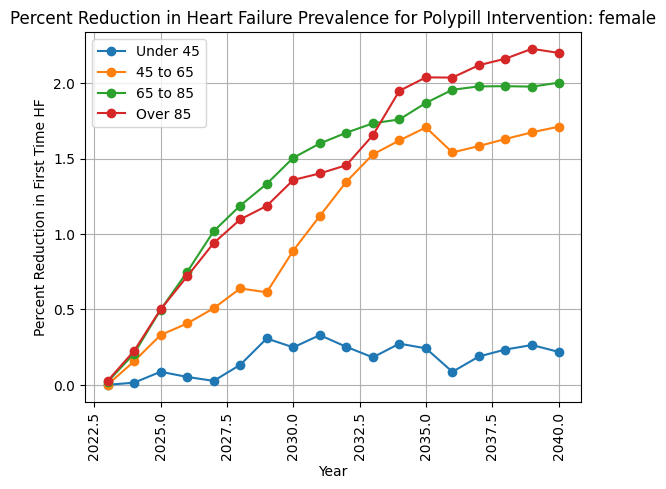

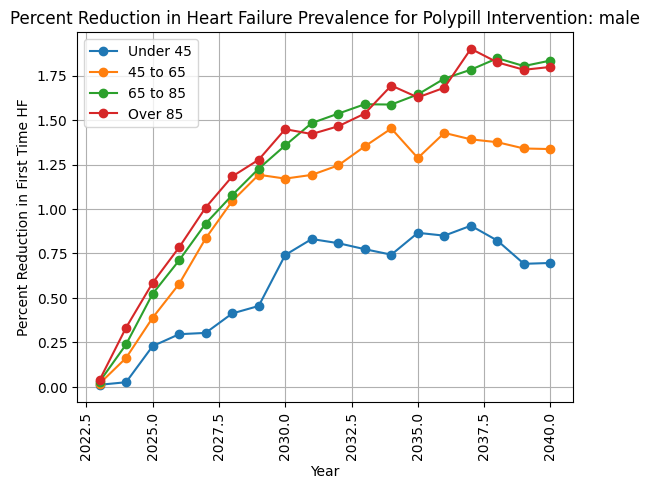

In [74]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Polypill Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

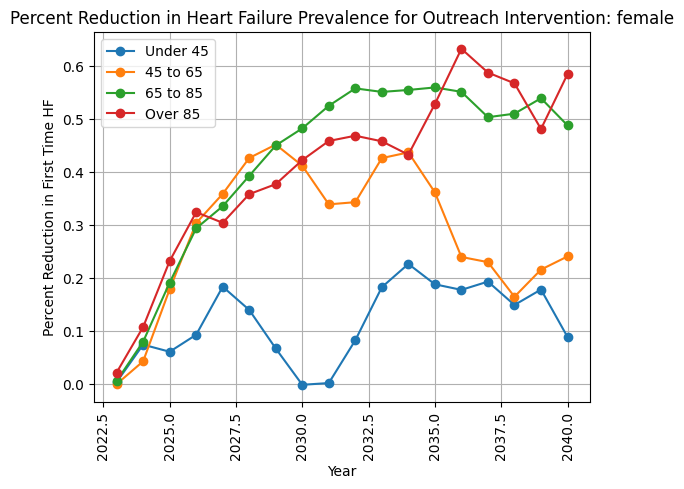

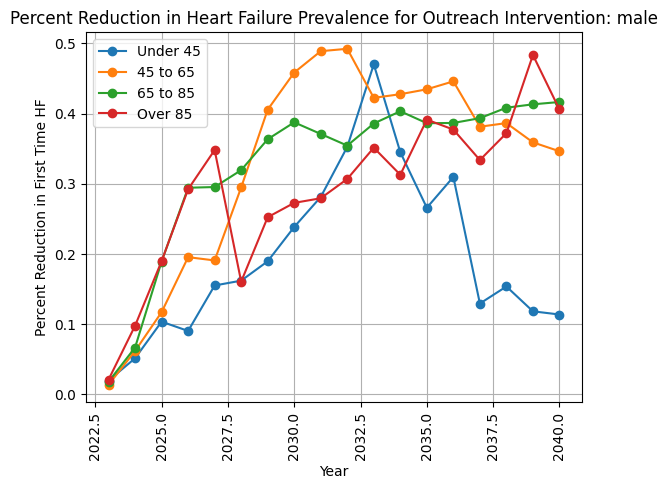

In [76]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Outreach Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

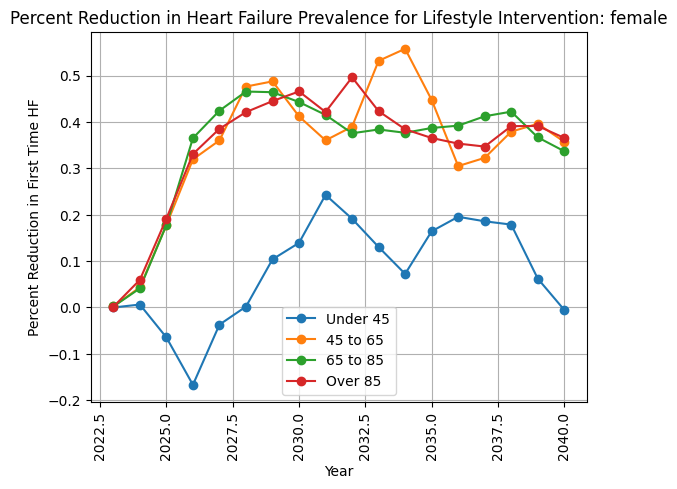

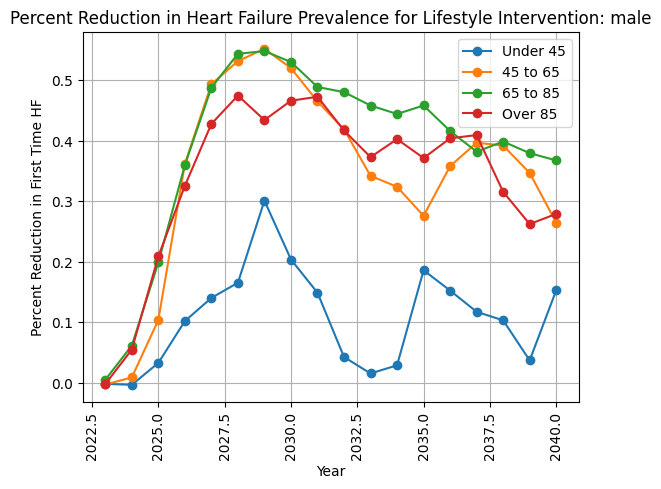

In [78]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='under_45') & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='45_to_65')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='65_to_85')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age_bucket=='over_85')  & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence for Lifestyle Intervention: {sex}')
    plt.legend(['Under 45','45 to 65','65 to 85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

## Testing Input Draws

### HF Prevalence Time Averted

In [47]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/north_dakota/2023_07_14_09_44_35/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [48]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/north_dakota/2023_07_14_09_44_35/count_data/'

In [49]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time_hf = state_person_time.loc[state_person_time['state'].isin(["heart_failure_residual", "heart_failure_from_ischemic_heart_disease"])].reset_index()
person_time_hf = person_time_hf.rename(columns = {'value':'ptvalue'})
per_time_group_hf = person_time_hf.groupby(['year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [50]:
hf_baseline = per_time_group_hf.loc[per_time_group_hf.scenario == 'baseline']
hf_baseline = hf_baseline.rename(columns = {'ptvalue':'baseline'})
HF_rate_prev = per_time_group_hf.merge(hf_baseline[['input_draw','year','baseline']], on=['input_draw','year']) 
HF_rate_prev['averted_count'] = HF_rate_prev['baseline'] - HF_rate_prev['ptvalue']
HF_rate_prev['averted_percent'] = 100*((HF_rate_prev['baseline'] - HF_rate_prev['ptvalue'])/HF_rate_prev['baseline'])
HF_rate_prev.head()

year  input_draw       scenario      ptvalue     baseline  averted_count  \
0  2023          29       baseline  6016.646133  6016.646133       0.000000   
1  2023          29  lifestyle_100  6016.262834  6016.646133       0.383299   
2  2023          29   outreach_100  6015.726215  6016.646133       0.919918   
3  2023          29   polypill_100  6015.112936  6016.646133       1.533196   
4  2023         232       baseline  5028.041068  5028.041068       0.000000   

   averted_percent  
0         0.000000  
1         0.006371  
2         0.015290  
3         0.025483  
4         0.000000

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

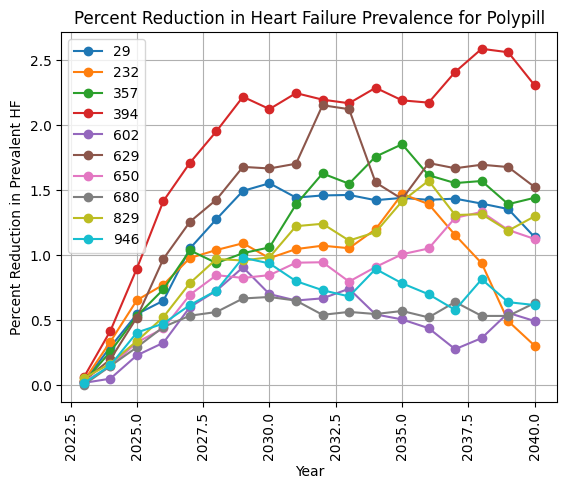

In [51]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Polypill')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

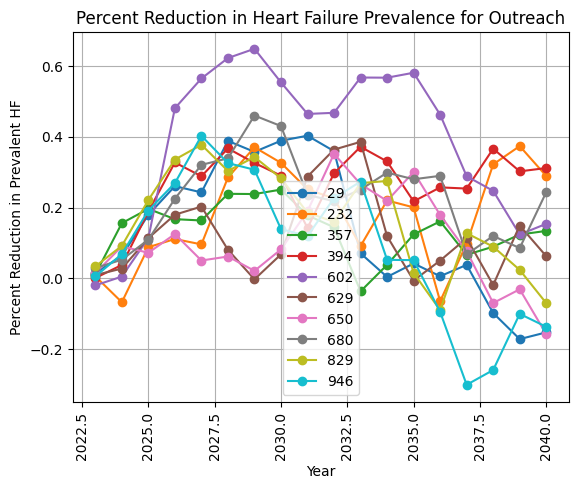

In [52]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Outreach')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

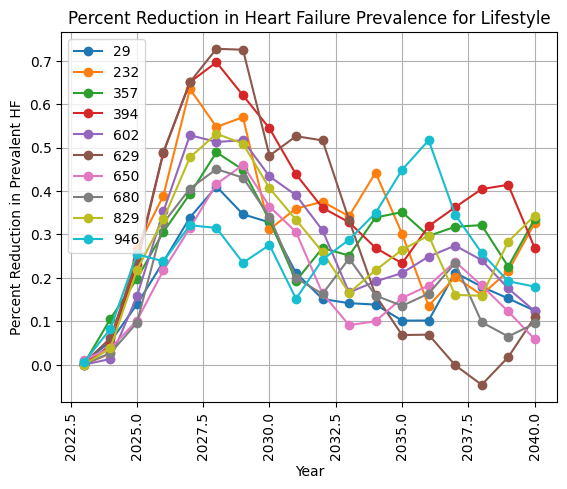

In [53]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Lifestyle')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

### DALYs Averted

In [54]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex  year  input_draw       scenario        ptvalue
0  Female  2023          29       baseline  108950.165640
1  Female  2023          29  lifestyle_100  108950.165640
2  Female  2023          29   outreach_100  108950.165640
3  Female  2023          29   polypill_100  108950.548939
4  Female  2023         232       baseline  108685.459274

In [55]:
daly_total_rate = daly_total.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex  input_draw  year       scenario         daly        ptvalue  \
0  Female          29  2023       baseline  4496.523696  108950.165640   
1  Female          29  2023  lifestyle_100  4496.523696  108950.165640   
2  Female          29  2023   outreach_100  4496.509872  108950.165640   
3  Female          29  2023   polypill_100  4496.593738  108950.548939   
4  Female          29  2024       baseline  4571.024332  109502.652977   

   daly_rate  
0   0.041271  
1   0.041271  
2   0.041271  
3   0.041272  
4   0.041744

In [56]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total_rate['averted_count'] = daly_total_rate['daly_rate'] - daly_total_rate['baseline']
daly_total_rate['averted_percent'] = 100*((daly_total_rate['daly_rate'] - daly_total_rate['baseline'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex  input_draw  year       scenario         daly        ptvalue  \
0  Female          29  2023       baseline  4496.523696  108950.165640   
1  Female          29  2023  lifestyle_100  4496.523696  108950.165640   
2  Female          29  2023   outreach_100  4496.509872  108950.165640   
3  Female          29  2023   polypill_100  4496.593738  108950.548939   
4  Female          29  2024       baseline  4571.024332  109502.652977   

   daly_rate  baseline  averted_count  averted_percent  
0   0.041271  0.041271   0.000000e+00         0.000000  
1   0.041271  0.041271   0.000000e+00         0.000000  
2   0.041271  0.041271  -1.268830e-07        -0.000307  
3   0.041272  0.041271   4.976812e-07         0.001206  
4   0.041744  0.041744   0.000000e+00         0.000000

Text(0, 0.5, 'Percent Reduction in DALYs')

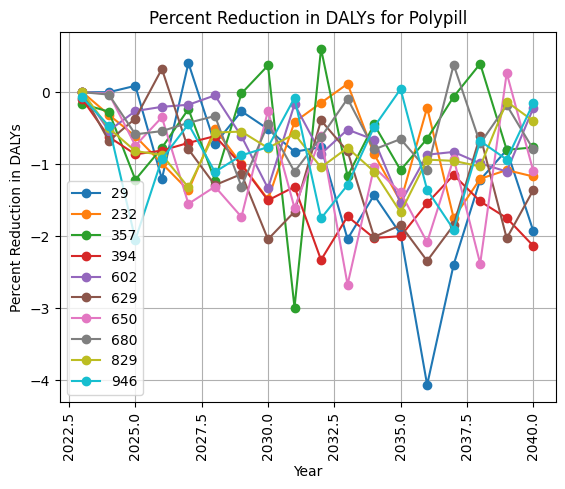

In [57]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='Male') & (daly_total_rate.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Polypill')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

Text(0, 0.5, 'Percent Reduction in DALYs')

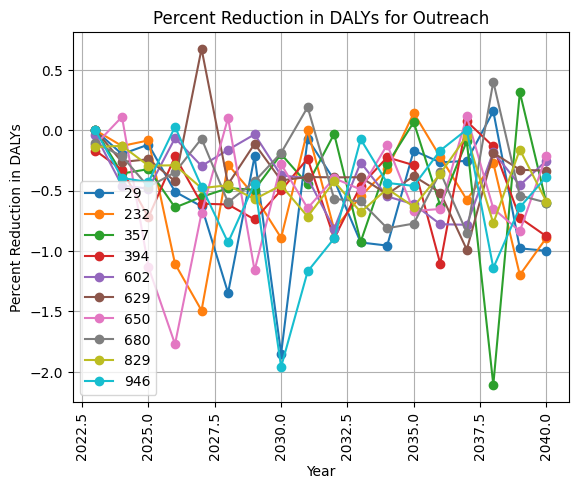

In [59]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='Male') & (daly_total_rate.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Outreach')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

Text(0, 0.5, 'Percent Reduction in DALYs')

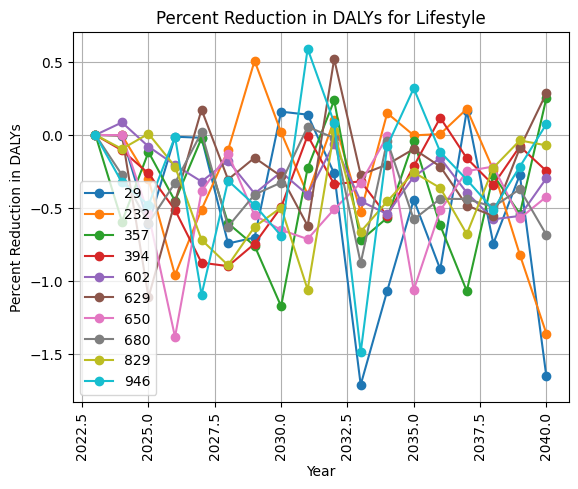

In [46]:
plt.figure()
for draw in daly_total_rate.input_draw.unique(): 
    subdata = daly_total_rate.loc[(daly_total_rate.input_draw==draw) & (daly_total_rate.sex=='Male') & (daly_total_rate.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in DALYs for Lifestyle')
plt.legend(daly_total_rate.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in DALYs')

## Risk Exposures

In [89]:
risks = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
risks.head()

Unnamed: 0     sex  year                            risk  \
0           0  female  2023  high_body_mass_index_in_adults   
1           1  female  2023  high_body_mass_index_in_adults   
2           2  female  2023  high_body_mass_index_in_adults   
3           3  female  2023  high_body_mass_index_in_adults   
4           4  female  2023  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age          value  
0  risk_exposure_time          29       baseline  25_to_29  835692.780297  
1  risk_exposure_time          29  lifestyle_100  25_to_29  835692.780297  
2  risk_exposure_time          29   lifestyle_50  25_to_29  835692.780297  
3  risk_exposure_time          29   outreach_100  25_to_29  835692.780297  
4  risk_exposure_time          29    outreach_50  25_to_29  835692.780297

In [86]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time = person_time.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.groupby(['sex','age', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex       age  year  input_draw       scenario      ptvalue
0  female  25_to_29  2023          29       baseline  27022.28063
1  female  25_to_29  2023          29  lifestyle_100  27022.28063
2  female  25_to_29  2023          29   lifestyle_50  27022.28063
3  female  25_to_29  2023          29   outreach_100  27022.28063
4  female  25_to_29  2023          29    outreach_50  27022.28063

In [95]:
risk_exp = risks.merge(per_time_age[['sex','age','input_draw','year','scenario','ptvalue']], on=['sex','age','input_draw','year','scenario'])
risk_exp['risk_exp'] = risk_exp['value'] / risk_exp['ptvalue']
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  female  2023  high_body_mass_index_in_adults   
1        1050  female  2023     high_fasting_plasma_glucose   
2        2100  female  2023            high_ldl_cholesterol   
3        3150  female  2023    high_systolic_blood_pressure   
4           1  female  2023  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age         value  \
0  risk_exposure_time          29       baseline  25_to_29  8.356928e+05   
1  risk_exposure_time          29       baseline  25_to_29  1.320725e+05   
2  risk_exposure_time          29       baseline  25_to_29  7.654238e+04   
3  risk_exposure_time          29       baseline  25_to_29  2.911479e+06   
4  risk_exposure_time          29  lifestyle_100  25_to_29  8.356928e+05   

       ptvalue    risk_exp  
0  27022.28063   30.926064  
1  27022.28063    4.887540  
2  27022.28063    2.832565  
3  27022.28063  107.743658  
4  27022.28063   30.926064

In [96]:
risk_exp = (risk_exp
                      .groupby(['sex','age', 'year','scenario','risk'])
                      .risk_exp.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

risk_exp.head()

sex       age  year       scenario                            risk  \
0  female  25_to_29  2023       baseline  high_body_mass_index_in_adults   
1  female  25_to_29  2023       baseline     high_fasting_plasma_glucose   
2  female  25_to_29  2023       baseline            high_ldl_cholesterol   
3  female  25_to_29  2023       baseline    high_systolic_blood_pressure   
4  female  25_to_29  2023  lifestyle_100  high_body_mass_index_in_adults   

         mean        2.5%       97.5%  
0   30.715274   30.390470   31.006332  
1    5.341261    4.846877    6.187954  
2    2.634736    2.558028    2.799935  
3  110.017126  107.879221  112.581477  
4   30.715274   30.390470   31.006332

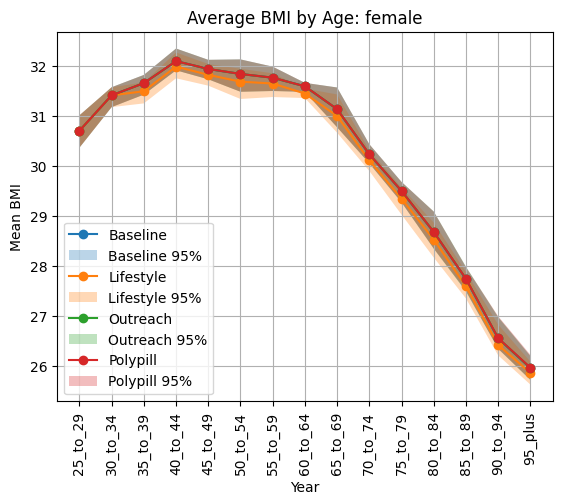

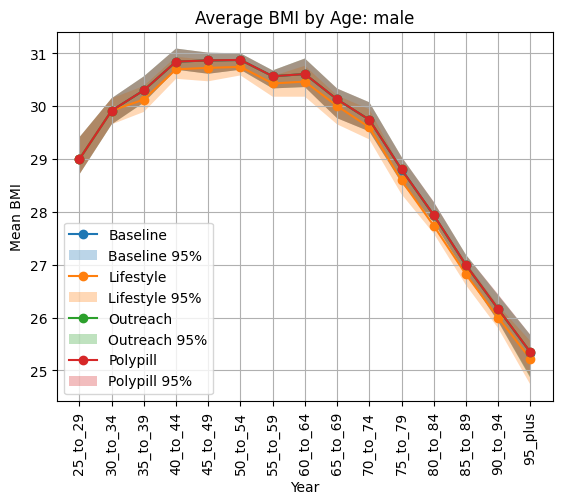

In [105]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_body_mass_index_in_adults') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average BMI by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean BMI')

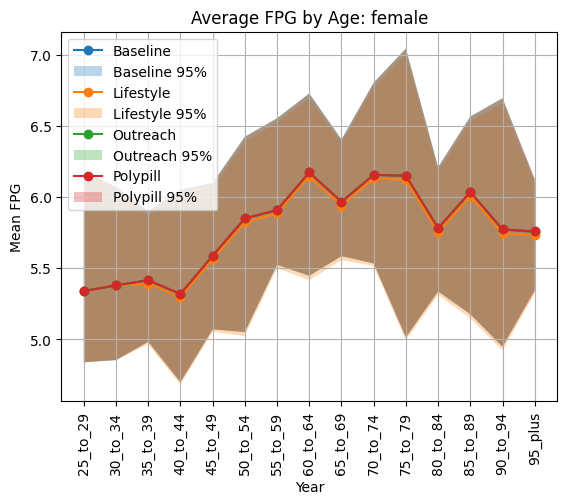

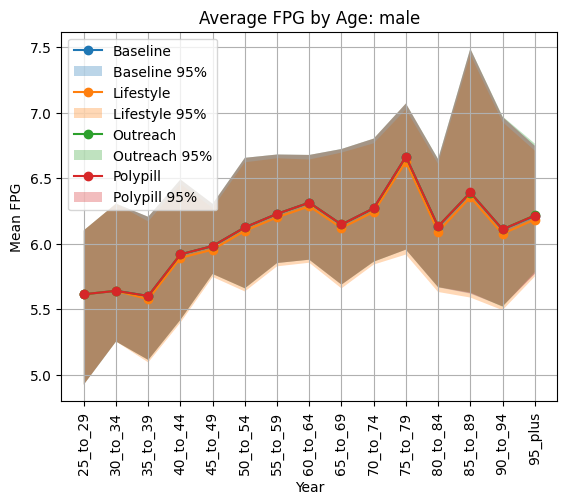

In [107]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_fasting_plasma_glucose') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average FPG by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean FPG')

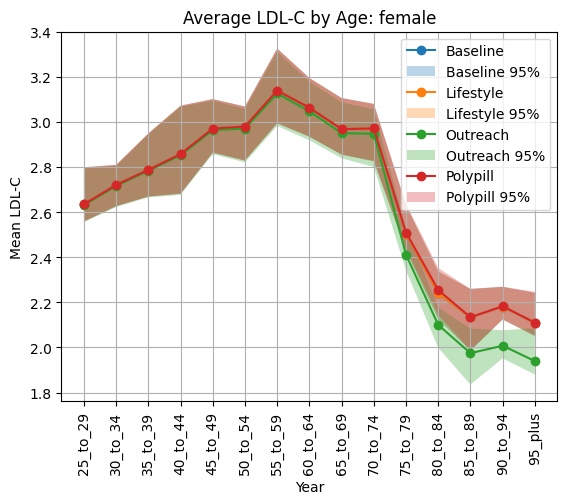

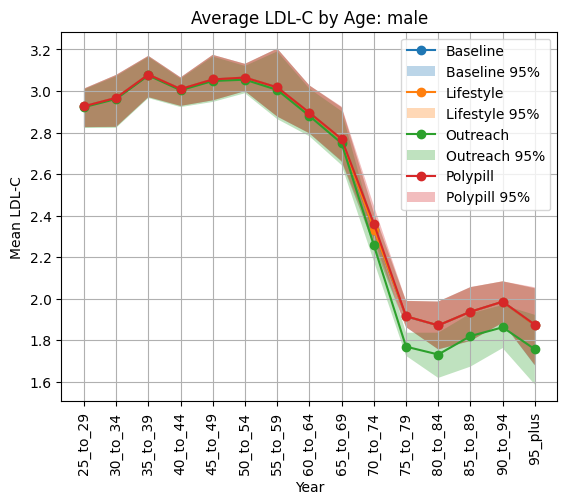

In [108]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_ldl_cholesterol') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average LDL-C by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean LDL-C')

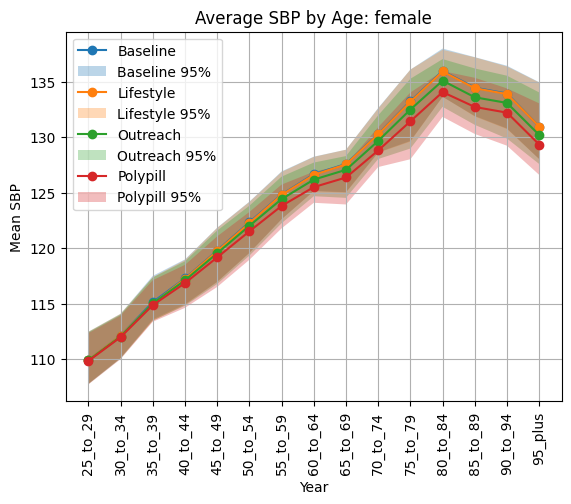

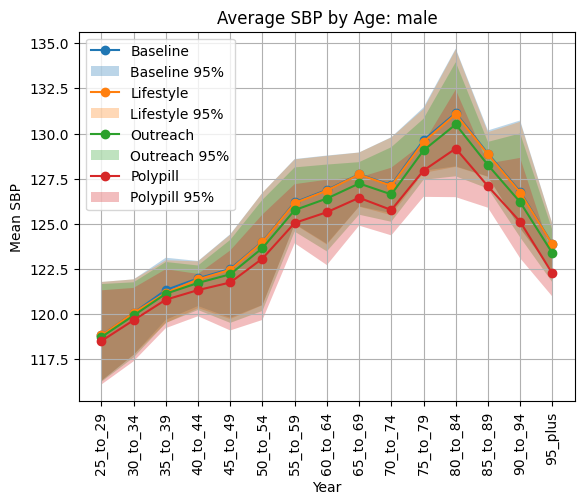

In [109]:
for sex in risk_exp.sex.unique(): 
    plt.figure()
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='baseline') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='lifestyle_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='outreach_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = risk_exp.loc[(risk_exp.sex==sex) & (risk_exp.risk=='high_systolic_blood_pressure') & (risk_exp.scenario=='polypill_100') & (risk_exp.year==2030)]
    plt.plot(subdata['age'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Average SBP by Age: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Mean SBP')